In [63]:
import numpy as np
from random import shuffle
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 20)

その分野の良いものを見つけたければ、その分野の専門家・マニア・オタクに聞くべきだ、素人がどんなに多くの票を入れたからと言って、それが良いものだとは思わない

という思想の下、玄人優先のランキングアルゴリズムを作る。誰の票を重く見るかを示す変数の決め方を変えれば、カスタマイズ可能になることが望ましい。

与えられる情報は、
①ノミネート数
②タイトルのID
③だれがどのタイトルに何票投票したか
④投票者各位がどのタイトルの中から投票タイトルを選択したか

となる。

In [64]:
#db = pd.read_csv("data.csv")

In [65]:
#   ミニテスト用
N = 10 #   ノミネートタイトル数
M = 10**2   #   投票者数
L = 5  #   投票者一人当たりのタイトル経験数スケール(目安)
K = 3  #   一人当たりの投票権利数

In [66]:
N = 100 #   ノミネートタイトル数
M = 10**4   #   投票者数
L = 10  #   投票者一人当たりのタイトル経験数スケール(目安)
K = 10  #   一人当たりの投票権利数

In [67]:
def make_nominated_title_db(N, value_vector=None, popularity_vector=None):
    col = ["id", "popularity", "experienced counter", "value", "simple vote", "simple vote ranking", "simple vote rate", "simple vote rate ranking", "corrected vote", "corrected vote ranking", "professional vote point", "professional ranking"]
    info = [[None for _ in range(len(col))] for _ in range(N)]
    nominated_title_db = pd.DataFrame(info, columns=col)
    nominated_title_db["id"] = nominated_title_db.index
    nominated_title_db["popularity"] = popularity_vector
    nominated_title_db["value"] = value_vector
    nominated_title_db["experienced counter"] = 0
    nominated_title_db["simple vote"] = 0
    nominated_title_db["corrected vote"] = 0
    nominated_title_db["professional vote point"] = 0
    nominated_title_db["corrected vote"] = 0

    return nominated_title_db

In [68]:
#   データ生成のセル
popularity_vector = np.exp(-5*np.arange(N)/N)
value_vector = np.random.randn(N) + (N - np.arange(N))/N
value_vector += -np.min(value_vector)
value_vector /= np.max(value_vector)
nominated_title_db = make_nominated_title_db(N, value_vector=value_vector, popularity_vector=popularity_vector)

def make_data(N, M, L, K, nominated_title_db):
    col = ["name", "experienced title list", "number of experienced title", "voted title info list", "poll", "waight"]
    info = [[None for _ in range(len(col))] for _ in range(M)]
    voter_db = pd.DataFrame(info, columns=col)
    voter_db["name"] = voter_db.index

    j1 = col.index("experienced title list")
    j2 = col.index("number of experienced title")
    waight_col_j = col.index("waight")
    voted_title_col_j = col.index("voted title info list")
    poll_col_j = col.index("poll")

    popularity_arr, value_arr = None, None
    if nominated_title_db.at[0, "popularity"] is not None:
        popularity_arr = np.array(list(nominated_title_db.loc[:,"popularity"].values))
    if nominated_title_db.at[0, "value"] is not None:
        value_arr = np.array(list(nominated_title_db.loc[:,"value"].values))

    for i in range(len(voter_db)):
        number_of_experienced_title = N
        for _ in range(int(np.log2(N/L))):
            number_of_experienced_title = np.random.randint(1,number_of_experienced_title+1)
        t = list(set(np.random.choice([i for i in range(N)], number_of_experienced_title, p=popularity_arr/np.sum(popularity_arr))))
        shuffle(t)
        voter_db.iat[i, j1] = t
        voter_db.iat[i, j2] = len(t)
        voter_db.iat[i, waight_col_j] = len(t)**0.5 #   ここはどうする？

        u = t[:np.random.randint(1, len(t)+1)]
        lst = []
        kh = np.random.randint(1, K+1, len(u))
        M = 0
        for h in range(len(u)):
            kh[h] += int(K*value_arr[u[h]])
            M += kh[h]
        while np.sum(kh) > K:
            h = np.random.randint(0,len(kh))
            if kh[h] > 0:
                kh[h] -= 1
                M -= 1
        for h, voted_point in enumerate(kh):
            if voted_point > 0:
                lst.append((u[h], voted_point))
        voter_db.iat[i, voted_title_col_j] = lst
        voter_db.iat[i, poll_col_j] = M
    
    voter_db.iloc[:,waight_col_j] *= K/voter_db.iloc[:,poll_col_j]  #   票数が少なかったら重み補正　ここはないほうが良い場合もあるかな
    voter_db.iloc[:,waight_col_j] /= sum(voter_db.iloc[:,waight_col_j])
    return voter_db
voter_db = make_data(N, M, L, K, nominated_title_db)
voter_db

,name,experienced title list,number of experienced title,voted title info list,poll,waight
0,0,"[32, 3, 90, 62, 14, 7]",6,"[(3, 7), (90, 3)]",10,0.000084
1,1,"[51, 3, 28, 2, 24, 16, 7, 8, 39, 13, 4, 43, 41]",13,"[(24, 10)]",10,0.000124
2,2,"[21, 20, 61, 4, 5, 35, 15, 1, 59, 30, 32, 47, ...",27,"[(21, 5), (20, 3), (61, 2)]",10,0.000178
3,3,"[13, 23, 56, 39, 14, 9, 32]",7,"[(13, 7), (56, 3)]",10,0.000091
4,4,"[23, 10, 16, 7, 43, 32, 33, 11, 52, 14, 0]",11,"[(10, 1), (7, 9)]",10,0.000114
...,...,...,...,...,...,...
9995,9995,[2],1,"[(2, 10)]",10,0.000034
9996,9996,"[9, 5]",2,"[(9, 10)]",10,0.000048
9997,9997,"[32, 0, 6, 4, 19, 46, 5, 34]",8,"[(32, 5), (0, 5)]",10,0.000097
9998,9998,"[71, 17, 40, 5, 4]",5,"[(71, 10)]",10,0.000077


In [69]:
def count_experiment(voter_db, nominated_title_db):
    j = list(voter_db.columns).index("experienced title list")
    k = list(nominated_title_db.columns).index("experienced counter")
    for i in range(len(voter_db)):
        for title_id in voter_db.iat[i, j]:
            nominated_title_db.iat[title_id, k] += 1
    nominated_title_db.sort_values("experienced counter", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    return nominated_title_db
count_experiment(voter_db, nominated_title_db)

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking
0,0,1.000000,3834,0.561617,0,None,None,None,0,None,0,None
1,1,0.951229,3683,0.419509,0,None,None,None,0,None,0,None
2,2,0.904837,3660,0.754078,0,None,None,None,0,None,0,None
3,3,0.860708,3558,0.709822,0,None,None,None,0,None,0,None
4,4,0.818731,3479,0.321860,0,None,None,None,0,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.008230,55,0.146341,0,None,None,None,0,None,0,None
96,93,0.009562,54,0.526022,0,None,None,None,0,None,0,None
97,97,0.007828,48,0.180419,0,None,None,None,0,None,0,None
98,98,0.007447,45,0.508585,0,None,None,None,0,None,0,None


In [70]:
def make_pointVector(N):
    point_vector = np.zeros(N)

    voted_title_col_j = list(voter_db.columns).index("voted title info list")
    waight_col_j = list(voter_db.columns).index("waight")

    for i in range(len(voter_db)):
        for title_id, voted_point in voter_db.iat[i,voted_title_col_j]:
            point_vector[title_id] += voted_point * voter_db.iat[i,waight_col_j]
    
    return point_vector
point_vector = make_pointVector(N)

In [71]:
def input_simple_vote_to_nominated_title_db(nominated_title_db, voter_db, N, M):
    simple_vote_col_j = list(nominated_title_db.columns).index("simple vote")
    simple_vote_ranking_col_j = list(nominated_title_db.columns).index("simple vote ranking")
    voted_title_col_j = list(voter_db.columns).index("voted title info list")
    nominated_title_db.sort_values("id", inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    for i in range(M):
        for title_id, vote_number in voter_db.iat[i, voted_title_col_j]:
            nominated_title_db.iat[title_id, simple_vote_col_j] += vote_number

    nominated_title_db.sort_values("simple vote", ascending=False, inplace=True)
    nominated_title_db["simple vote ranking"] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, simple_vote_col_j] == nominated_title_db.iat[i+1, simple_vote_col_j]:
            nominated_title_db.iat[i+1, simple_vote_ranking_col_j] = nominated_title_db.iat[i, simple_vote_ranking_col_j]
    return nominated_title_db
nominated_title_db = input_simple_vote_to_nominated_title_db(nominated_title_db, voter_db, N, M)
nominated_title_db.reset_index(drop=True, inplace=True)
nominated_title_db

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking
0,2,0.904837,3660,0.754078,5067,1,None,None,0,None,0,None
1,3,0.860708,3558,0.709822,4794,2,None,None,0,None,0,None
2,5,0.778801,3298,0.769173,4485,3,None,None,0,None,0,None
3,0,1.000000,3834,0.561617,4088,4,None,None,0,None,0,None
4,7,0.704688,3080,0.791730,3833,5,None,None,0,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
95,98,0.007447,45,0.508585,28,95,None,None,0,None,0,None
96,80,0.018316,114,0.098032,26,97,None,None,0,None,0,None
97,95,0.008652,55,0.164071,14,98,None,None,0,None,0,None
98,86,0.013569,94,0.230911,13,99,None,None,0,None,0,None


In [72]:
def make_simple_vote_rate_ranking(nominated_title_db):
    rate_j = list(nominated_title_db.columns).index("simple vote rate")
    ranking_j = list(nominated_title_db.columns).index("simple vote rate ranking")
    
    nominated_title_db["simple vote rate"] = nominated_title_db["simple vote"] / nominated_title_db["experienced counter"]
    nominated_title_db.sort_values("simple vote rate", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)

    nominated_title_db["simple vote rate ranking"] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, rate_j] == nominated_title_db.iat[i+1, rate_j]:
            nominated_title_db.iat[i+1, ranking_j] = nominated_title_db.iat[i, ranking_j]
    return nominated_title_db
make_simple_vote_rate_ranking(nominated_title_db)

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking
0,32,0.201897,1135,1.000000,1978,19,1.742731,1,0,None,0,None
1,24,0.301194,1618,0.912298,2759,11,1.705192,2,0,None,0,None
2,44,0.110803,685,0.918923,1131,27,1.651095,3,0,None,0,None
3,84,0.014996,96,0.882913,153,68,1.593750,4,0,None,0,None
4,87,0.012907,92,0.674004,145,71,1.576087,5,0,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
95,59,0.052340,344,0.171503,103,76,0.299419,96,0,None,0,None
96,95,0.008652,55,0.164071,14,98,0.254545,97,0,None,0,None
97,80,0.018316,114,0.098032,26,97,0.228070,98,0,None,0,None
98,97,0.007828,48,0.180419,8,100,0.166667,99,0,None,0,None


In [73]:
def input_corrected_vote_to_nominated_title_db(nominated_title_db, voter_db, N, M):
    corrected_vote_col_j = list(nominated_title_db.columns).index("corrected vote")
    corrected_vote_ranking_col_j = list(nominated_title_db.columns).index("corrected vote ranking")
    voted_title_col_j = list(voter_db.columns).index("voted title info list")
    waight_col_j = list(voter_db.columns).index("waight")
    nominated_title_db.sort_values("id", inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    for i in range(M):
        for title_id, vote_number in voter_db.iat[i, voted_title_col_j]:
            nominated_title_db.iat[title_id, corrected_vote_col_j] += vote_number*voter_db.iat[i, waight_col_j]

    nominated_title_db.sort_values("corrected vote", ascending=False, inplace=True)
    nominated_title_db["corrected vote ranking"] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, corrected_vote_col_j] == nominated_title_db.iat[i+1, corrected_vote_col_j]:
            nominated_title_db.iat[i+1, corrected_vote_ranking_col_j] = nominated_title_db.iat[i, corrected_vote_ranking_col_j]
    return nominated_title_db
nominated_title_db = input_corrected_vote_to_nominated_title_db(nominated_title_db, voter_db, N, M)
nominated_title_db.reset_index(drop=True, inplace=True)
nominated_title_db

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking
0,2,0.904837,3660,0.754078,5067,1,1.384426,10,0.481185,1,0,None
1,3,0.860708,3558,0.709822,4794,2,1.347386,12,0.472686,2,0,None
2,5,0.778801,3298,0.769173,4485,3,1.359915,11,0.436290,3,0,None
3,13,0.522046,2458,0.830344,3724,6,1.515053,7,0.400335,4,0,None
4,7,0.704688,3080,0.791730,3833,5,1.244481,15,0.377044,5,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
95,94,0.009095,58,0.223621,34,94,0.586207,76,0.002343,96,0,None
96,98,0.007447,45,0.508585,28,95,0.622222,73,0.002147,97,0,None
97,86,0.013569,94,0.230911,13,99,0.138298,100,0.001670,98,0,None
98,95,0.008652,55,0.164071,14,98,0.254545,97,0.001016,99,0,None


In [74]:
def make_pointFlowMatrix(N):
    point_flow_matrix = np.zeros((N, N))
    point_flow_vector = np.zeros(N)

    counter = np.zeros((N, N)) + 1

    voted_title_col_j = list(voter_db.columns).index("voted title info list")
    waight_col_j = list(voter_db.columns).index("waight")

    for i in range(len(voter_db)):
        for pivot_title_id, pivot_voted_point in voter_db.iat[i,voted_title_col_j]:
            for title_id, voted_point in voter_db.iat[i,voted_title_col_j]:
                point_flow_matrix[pivot_title_id, title_id] += (voted_point - pivot_voted_point) * voter_db.iat[i,waight_col_j]
                counter[pivot_title_id, title_id] += 1
    #point_flow_matrix[point_flow_matrix<0] = 0
    point_flow_matrix /= counter ** 0.5
    point_flow_vector = np.sum(point_flow_matrix, axis=0)
    
    return point_flow_matrix, point_flow_vector
point_flow_matrix, point_flow_vector = make_pointFlowMatrix(N)
pd.DataFrame(point_flow_matrix)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,-0.000008,0.000029,0.000615,-0.001373,0.000808,-0.000272,-0.000121,-0.000149,0.000509,...,-0.000234,0.000000,0.000000,0.000000,0.000291,-0.000108,0.0,0.000000,0.0,0.000194
1,0.000008,0.000000,0.000088,0.000215,-0.000430,0.000634,-0.000044,0.000181,0.000358,0.000377,...,-0.000369,-0.000178,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,-0.000029,-0.000088,0.000000,-0.000639,-0.000573,0.000018,-0.000996,0.000414,-0.000398,-0.000628,...,-0.000639,0.000000,-0.000091,0.000000,0.000000,0.000000,0.0,-0.000485,0.0,0.000000
3,-0.000615,-0.000215,0.000639,0.000000,-0.000609,0.000599,-0.000686,-0.000407,-0.000384,-0.000904,...,-0.000295,0.000000,0.000000,-0.000064,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.001373,0.000430,0.000573,0.000609,0.000000,0.001173,-0.000115,0.001113,-0.000357,0.000821,...,0.000000,0.000000,0.000000,-0.000111,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
96,0.000000,0.000000,0.000000,0.000000,0.000000,0.000042,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
97,0.000000,0.000000,0.000485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
98,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000340,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [75]:
def input_professional_to_nominated_title_db(nominated_title_db, point_flow_vector, N):
    point_j = list(nominated_title_db.columns).index("professional vote point")
    ranking_j = list(nominated_title_db.columns).index("professional ranking")

    nominated_title_db.sort_values("id", ascending=True, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    nominated_title_db["professional vote point"] = point_flow_vector
    nominated_title_db.sort_values("professional vote point", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    nominated_title_db.iloc[:, ranking_j] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, point_j] == nominated_title_db.iat[i+1, point_j]:
            nominated_title_db.iat[i+1, ranking_j] = nominated_title_db.iat[i, ranking_j]
    return nominated_title_db
nominated_title_db = input_professional_to_nominated_title_db(nominated_title_db, point_flow_vector, N)
nominated_title_db.reset_index(drop=True, inplace=True)
nominated_title_db

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking
0,32,0.201897,1135,1.000000,1978,19,1.742731,1,0.242824,14,0.028939,1
1,24,0.301194,1618,0.912298,2759,11,1.705192,2,0.309793,9,0.026524,2
2,13,0.522046,2458,0.830344,3724,6,1.515053,7,0.400335,4,0.023904,3
3,47,0.095369,624,0.956244,930,32,1.490385,8,0.113222,27,0.019089,4
4,18,0.406570,2066,0.845619,3206,8,1.551791,6,0.349316,7,0.016768,5
...,...,...,...,...,...,...,...,...,...,...,...,...
95,37,0.157237,914,0.281171,440,51,0.481400,85,0.040507,52,-0.011059,96
96,11,0.576950,2662,0.519324,2438,15,0.915853,38,0.219685,16,-0.011495,97
97,23,0.316637,1682,0.334388,981,31,0.583234,78,0.096373,33,-0.011911,98
98,6,0.740818,3176,0.487488,2582,13,0.812972,50,0.237659,15,-0.014472,99


In [76]:
def add_value_ranking(nominated_title_db, N):
    nominated_title_db["value ranking"] = 0
    nominated_title_db.sort_values("value", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    nominated_title_db.loc[:, "value ranking"] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, -1] == nominated_title_db.iat[i+1, -1]:
            nominated_title_db.iat[i+1, -1] = nominated_title_db.iat[i, -1]
    return nominated_title_db
add_value_ranking(nominated_title_db, N)

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking,value ranking
0,32,0.201897,1135,1.000000,1978,19,1.742731,1,0.242824,14,0.028939,1,1
1,47,0.095369,624,0.956244,930,32,1.490385,8,0.113222,27,0.019089,4,2
2,44,0.110803,685,0.918923,1131,27,1.651095,3,0.132646,26,0.016682,7,3
3,24,0.301194,1618,0.912298,2759,11,1.705192,2,0.309793,9,0.026524,2,4
4,29,0.234570,1313,0.887426,1843,20,1.403656,9,0.208630,18,0.015913,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.008652,55,0.164071,14,98,0.254545,97,0.001016,99,-0.000314,44,96
96,96,0.008230,55,0.146341,44,89,0.800000,51,0.003015,92,-0.000318,45,97
97,80,0.018316,114,0.098032,26,97,0.228070,98,0.002623,95,-0.001554,59,98
98,85,0.014264,102,0.035252,40,92,0.392157,91,0.003325,91,-0.002001,63,99


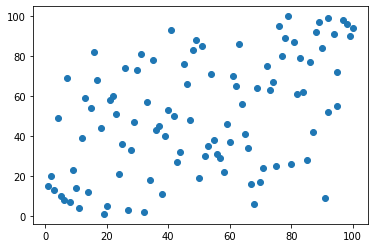

In [77]:
plt.scatter(nominated_title_db["simple vote ranking"], nominated_title_db["value ranking"])

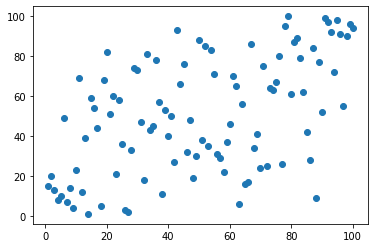

In [78]:
plt.scatter(nominated_title_db["corrected vote ranking"], nominated_title_db["value ranking"])

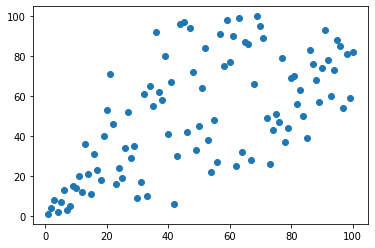

In [79]:
plt.scatter(nominated_title_db["professional ranking"], nominated_title_db["value ranking"])

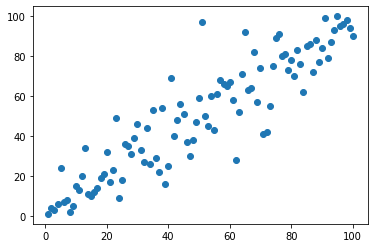

In [80]:
plt.scatter(nominated_title_db["simple vote rate ranking"], nominated_title_db["value ranking"])

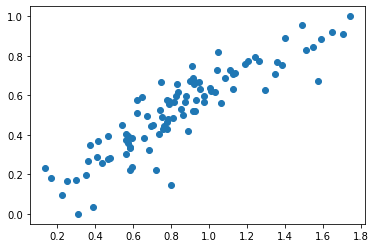

In [81]:
plt.scatter(nominated_title_db["simple vote rate"], nominated_title_db["value"])

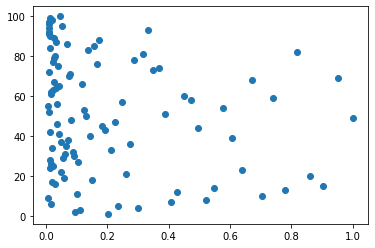

In [82]:
plt.scatter(nominated_title_db["popularity"], nominated_title_db["value ranking"])

In [83]:
def tuning(nominated_title_db, point_flow_matrix, point_flow_vector, N):
    for _ in range(10**5):
        point_flow_vector *= N / np.sum(point_flow_vector**2)
        point_flow_vector = np.dot(point_flow_matrix, point_flow_vector)

    nominated_title_db = input_professional_to_nominated_title_db(nominated_title_db, point_flow_vector, N)
    nominated_title_db.reset_index(drop=True, inplace=True)

tuning(nominated_title_db, point_flow_matrix, point_flow_vector, N)

In [84]:
pd.set_option('display.max_rows', None)

nominated_title_db.sort_values("simple vote rate", ascending=False)

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking,value ranking
0,32,0.201897,1135,1.000000,1978,19,1.742731,1,0.242824,14,0.030578,1,1
1,24,0.301194,1618,0.912298,2759,11,1.705192,2,0.309793,9,0.026156,2,4
4,44,0.110803,685,0.918923,1131,27,1.651095,3,0.132646,26,0.019906,5,3
51,84,0.014996,96,0.882913,153,68,1.593750,4,0.019988,63,-0.001057,52,6
20,87,0.012907,92,0.674004,145,71,1.576087,5,0.013788,70,0.002768,21,24
6,18,0.406570,2066,0.845619,3206,8,1.551791,6,0.349316,7,0.016791,7,7
2,13,0.522046,2458,0.830344,3724,6,1.515053,7,0.400335,4,0.023918,3,8
3,47,0.095369,624,0.956244,930,32,1.490385,8,0.113222,27,0.021394,4,2
5,29,0.234570,1313,0.887426,1843,20,1.403656,9,0.208630,18,0.016851,6,5
11,2,0.904837,3660,0.754078,5067,1,1.384426,10,0.481185,1,0.009563,12,15


In [85]:
pd.set_option('display.max_rows', None)

ranking_db = nominated_title_db[["id", "popularity", "value", "value ranking", "simple vote ranking", "corrected vote ranking", "simple vote rate ranking", "professional ranking"]]
ranking_db.sort_values("value ranking")

,id,popularity,value,value ranking,simple vote ranking,corrected vote ranking,simple vote rate ranking,professional ranking
0,32,0.201897,1.000000,1,19,14,1,1
3,47,0.095369,0.956244,2,32,27,8,4
4,44,0.110803,0.918923,3,27,26,3,5
1,24,0.301194,0.912298,4,11,9,2,2
5,29,0.234570,0.887426,5,20,18,9,6
51,84,0.014996,0.882913,6,68,63,4,52
6,18,0.406570,0.845619,7,8,7,6,7
2,13,0.522046,0.830344,8,6,4,7,3
28,99,0.007083,0.821449,9,91,88,24,29
46,7,0.704688,0.791730,10,5,5,15,47


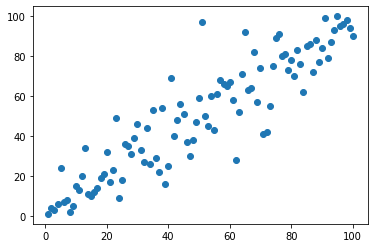

In [90]:
plt.scatter(nominated_title_db["simple vote rate ranking"], nominated_title_db["value ranking"])

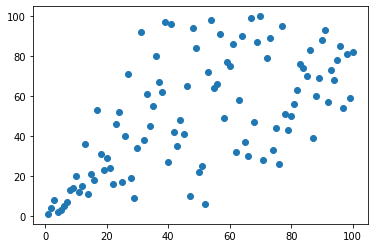

In [91]:
plt.scatter(nominated_title_db["professional ranking"], nominated_title_db["value ranking"])

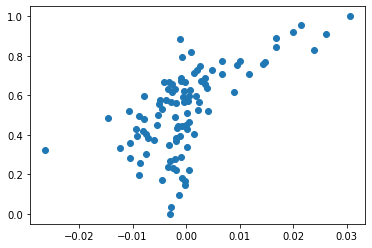

In [93]:
plt.scatter(nominated_title_db["professional vote point"], nominated_title_db["value"])

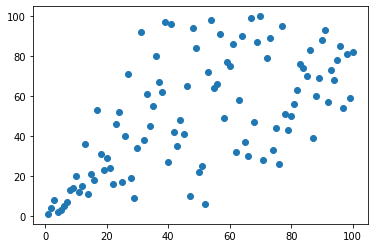

In [87]:
plt.scatter(nominated_title_db["professional ranking"], nominated_title_db["value ranking"])